## Homework

### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`



In [2]:
# Standard data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter utilities
from IPython.display import display

# Machine learning — preprocessing & modeling
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

# Machine learning — evaluation metrics
from sklearn.metrics import (
    mutual_info_score,
    accuracy_score,
    roc_curve,
    auc,
    roc_auc_score
)

# Utilities
from collections import Counter
from tqdm.auto import tqdm


# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv


In [3]:
df = pd.read_csv('course_lead_scoring.csv')

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [5]:
for c in df.columns:
    if df[c].dtype == 'object':
       df[c] = df[c].fillna('NA')
    else:
         df[c] = df[c].fillna(0.0)

In [6]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`



In [8]:
vars_to_check = [
    'lead_score',
    'number_of_courses_viewed',
    'interaction_count',
    'annual_income'
]

results = {}
for v in vars_to_check:
    s = roc_auc_score(y_train, df_train[v])
    if s < 0.5:
        s = roc_auc_score(y_train, -df_train[v])
        direction = 'inverted'
    else:
        direction = 'direct'
    results[v] = (s, direction)

for v, (s, direction) in results.items():
    print(f"{v}: AUC={s:.3f} ({direction})")

best_var = max(results.items(), key=lambda x: x[1][0])
print("\nBest variable:", best_var[0], "with AUC =", f"{best_var[1][0]:.3f}")

lead_score: AUC=0.614 (direct)
number_of_courses_viewed: AUC=0.764 (direct)
interaction_count: AUC=0.738 (direct)
annual_income: AUC=0.552 (direct)

Best variable: number_of_courses_viewed with AUC = 0.764


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92




In [9]:
# One-hot encode with DictVectorizer, train logistic regression, compute AUC on validation set
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]  # Probability of positive class
auc = roc_auc_score(y_val, y_pred)
print(f"AUC: {auc:.2f}")

AUC: 0.82


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745




Intersection approx. at threshold = 0.980
Precision = 0.000, Recall = 0.000


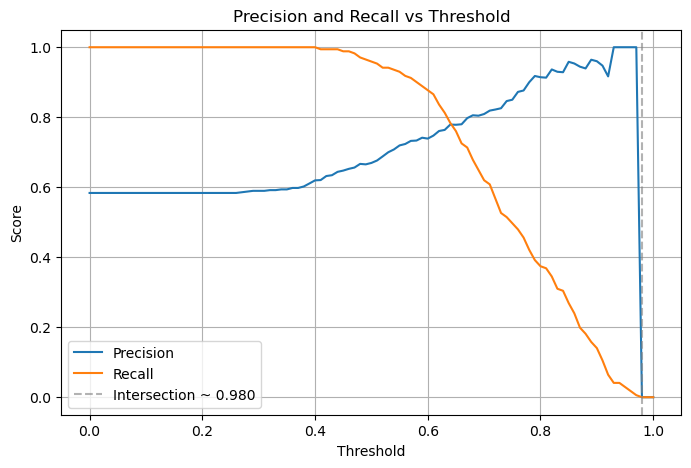

In [41]:
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.0, 1.01, 0.01)  # Include 1.0

precisions = []
recalls = []

for t in thresholds:
    y_hat = (y_pred >= t).astype(int)
    prec = precision_score(y_val, y_hat, zero_division=0)
    rec = recall_score(y_val, y_hat, zero_division=0)
    precisions.append(prec)
    recalls.append(rec)

precisions = np.array(precisions)
recalls = np.array(recalls)

# Find threshold where precision ≈ recall (minimize absolute difference)
diffs = np.abs(precisions - recalls)
best_idx = np.argmin(diffs)
best_threshold = thresholds[best_idx]

print(f"Intersection approx. at threshold = {best_threshold:.3f}")
print(f"Precision = {precisions[best_idx]:.3f}, Recall = {recalls[best_idx]:.3f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.axvline(best_threshold, color='gray', linestyle='--', alpha=0.6,
            label=f'Intersection ~ {best_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74




In [24]:
from sklearn.metrics import f1_score

thresholds = np.arange(0.0, 1.01, 0.01)  # Include 1.0 for completeness
f1_scores = []

for t in thresholds:
    y_hat = (y_pred >= t).astype(int)
    f1 = f1_score(y_val, y_hat)
    f1_scores.append(f1)

f1_scores = np.array(f1_scores)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold (max F1): {best_threshold:.2f}")
print(f"F1 at best threshold: {f1_scores[best_idx]:.3f}")

Best threshold (max F1): 0.57
F1 at best threshold: 0.812


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36




In [25]:
from sklearn.model_selection import KFold

# 5-Fold CV evaluation on df_full_train

kf = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kf.split(df_full_train):
    df_train_f = df_full_train.iloc[train_idx].reset_index(drop=True)
    df_val_f = df_full_train.iloc[val_idx].reset_index(drop=True)

    y_train_f = df_train_f['converted'].values
    y_val_f = df_val_f['converted'].values

    del df_train_f['converted']
    del df_val_f['converted']

    train_dicts = df_train_f.to_dict(orient='records')
    val_dicts = df_val_f.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train_f)

    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val_f, y_pred)
    scores.append(auc)

scores = np.array(scores)
print("AUC scores on folds:", np.round(scores, 3))
print("Mean AUC: %.3f" % scores.mean())
print("Std AUC: %.3f" % scores.std())

AUC scores on folds: [0.806 0.871 0.775 0.802 0.856]
Mean AUC: 0.822
Std AUC: 0.036


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.



In [26]:
# 5-Fold CV for hyperparameter tuning of C

Cs = [0.000001, 0.001, 1]
kf = KFold(n_splits=5, shuffle=True, random_state=1)

results = {}

for C in Cs:
    scores = []
    for train_idx, val_idx in kf.split(df_full_train):
        df_train_f = df_full_train.iloc[train_idx].reset_index(drop=True)
        df_val_f = df_full_train.iloc[val_idx].reset_index(drop=True)

        y_train_f = df_train_f['converted'].values
        y_val_f = df_val_f['converted'].values

        del df_train_f['converted']
        del df_val_f['converted']

        train_dicts = df_train_f.to_dict(orient='records')
        val_dicts = df_val_f.to_dict(orient='records')

        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(train_dicts)
        X_val = dv.transform(val_dicts)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train_f)

        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val_f, y_pred)
        scores.append(auc)

    scores = np.array(scores)
    mean_auc = scores.mean()
    std_auc = scores.std()
    results[C] = (mean_auc, std_auc)
    print(f"C={C}: mean={mean_auc:.3f}, std={std_auc:.3f}")

# select best C: highest mean (rounded to 3 decimals), tie-breaker: lowest std (rounded), then smallest C
best_C = sorted(
    results.items(),
    key=lambda kv: (-round(kv[1][0], 3), round(kv[1][1], 3), kv[0])
)[0][0]

best_mean, best_std = results[best_C]
print(f"\nBest C: {best_C} -> mean={best_mean:.3f}, std={best_std:.3f}")

C=1e-06: mean=0.560, std=0.024
C=0.001: mean=0.867, std=0.029
C=1: mean=0.822, std=0.036

Best C: 0.001 -> mean=0.867, std=0.029
